In [198]:
import os

# Data
import numpy as np
import pandas as pd

# Audio
import librosa
import librosa.display
from pydub import AudioSegment
import soundfile as sf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Deep Learning Visualization
from sklearn.metrics import confusion_matrix

### Split Dataset

Create train, validation and test datasets in 80%, 10% and 10% respectively.
Also create classes dictionary to map the classes to integers, alphabetically sorted.

In [199]:
def split_dataset(df, train_size=0.8, val_size=0.1, test_size=0.1):
    # Split the dataset into training, validation and test sets
    df_train, df_val = train_test_split(df, test_size=1-train_size, random_state=42, stratify=df['Class'])
    df_val, df_test = train_test_split(df_val, test_size=(test_size/(val_size+test_size)), random_state=42, stratify=df_val['Class'])

    # Create classes mapping alphabetically
    classes = df['Class'].unique()
    classes.sort()
    classes_mapping = {classes[i]: i for i in range(len(classes))}
    # Reverse the classes_mapping dictionary
    reverse_classes_mapping = {v: k for k, v in classes_mapping.items()}

    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_val = df_val.sample(frac=1).reset_index(drop=True)
    df_test = df_test.sample(frac=1).reset_index(drop=True)

    return df_train, df_val, df_test, classes, classes_mapping, reverse_classes_mapping

def plot_split(df_train, df_val, df_test):
    # Combine the datasets with an additional column indicating the set
    df_train['Set'] = 'Train'
    df_val['Set'] = 'Validation'
    df_test['Set'] = 'Test'

    # Concatenate all dataframes
    df_combined = pd.concat([df_train, df_val, df_test])

    # Plot number of files per class in each set not stacked
    plt.figure(figsize=(14, 8))
    sns.countplot(data=df_combined, x='Class', hue='Set')
    plt.title('Number of Files per Class in Each Set')
    plt.xticks(rotation=90, ha='right', fontsize=10)  # Adjust fontsize and alignment
    plt.legend(title='Set')
    plt.tight_layout()  # Adjust layout to make room for labels
    plt.show()

## Preprocess Audios

As most audios are 3 seconds more or less, the time windows that will be used will be 3 seconds

Sampling rate was 256000 but BirdNET takes 48000, so 48000 will be used. It just changes the resolution of the audio.

In [200]:
# Function to preprocess audio
def preprocess_audio(file_path, target_sr=48000, duration=3):
    # Load audio
    signal, sr = librosa.load(file_path, sr=target_sr, mono=True)
    
    # Calculate the maximum length in samples and min length in samples
    max_length = target_sr * duration  # e.g., 48000 * 3
    min_length = target_sr * 1  # e.g., 48000 * 1
    
    # If the signal is shorter than the desired length, pad with silence
    if len(signal) <= max_length:
        padding = max_length - len(signal)
        pad_left = padding // 2
        pad_right = padding - pad_left
        signal = np.pad(signal, (pad_left, pad_right), mode='constant')
        return [signal]
    
    # If the signal is longer than the desired length, split into 3-second windows
    elif len(signal) > max_length:
        segments = []

        for start in range(0, len(signal), max_length):
            end = start + max_length
            segment = signal[start:end]
            # if min_length < len(segment) <= max_length:
            #     padding = max_length - len(segment)
            #     pad_left = padding // 2
            #     pad_right = padding - pad_left
            #     segment = np.pad(segment, (pad_left, pad_right), mode='constant')
                    
            segments.append(segment)
        return segments
    
    # If the signal is exactly the desired length, return as is
    else:
        return [signal]

# # Test preprocess on a single file
# sample_file = os.path.join(df_train["File"][0])
# processed_audios = preprocess_audio(sample_file, target_sr=48000, duration=3)

# # Visualize waveforms

# # print class
# print(f"Class: {df_train['Class'][0]}")

# processed_audio = processed_audios[0]
# plt.figure(figsize=(10, 4))
# librosa.display.waveshow(processed_audio, sr=48000)
# plt.title(f"Processed Audio Waveform")
# plt.show()

# # Mel spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(y=processed_audio, sr=48000)
# mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# # Visualize mel spectrogram
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title(f"Mel Spectrogram")
# plt.tight_layout()
# plt.show()

# # Listen audio
# import IPython.display as ipd
# ipd.Audio(processed_audio, rate=48000)

In [201]:
# # take 25 random samples of different classes and plot in a grid with its class
# # Select 25 random samples
# random_samples = df_train.sample(25, random_state=42)

# # Create a grid of plots
# fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# # Flatten the axes
# axes = axes.ravel()

# # Loop through all the samples

# for i, (_, row) in enumerate(random_samples.iterrows()):
#     # Load the audio file
#     signal, sr = librosa.load(row['File'], sr=48000)

#     # preprocess the audio
#     processed_audios = preprocess_audio(row['File'], target_sr=48000, duration=3)
    
#     # Calculate the mel spectrogram
#     mel_spectrogram = librosa.feature.melspectrogram(y=processed_audios[0], sr=48000)
#     mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
#     # Plot the mel spectrogram
#     axes[i].imshow(mel_spectrogram, origin='lower')
#     axes[i].set_title(f"{row['Class']} ({classes_mapping[row['Class']]})")
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

# Data Generators

## Data Augmentation

In [202]:
from pydub import AudioSegment

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    augmented_signal = signal + noise_factor * noise
    return augmented_signal

def shift_time(signal, shift_max=0.4):
    shift = np.random.randint(int(shift_max * len(signal)))
    augmented_signal = np.roll(signal, shift)
    return augmented_signal

# Mix Up
def mix_up(signal1, signal2, alpha=0.5):
    mixed_signal = alpha * signal1 + (1 - alpha) * signal2
    return mixed_signal

In [203]:
# # Check data augmentation in the same audio, plot the original and the augmented audio with each of the changes
# # Load the audio file
# sample_file = df_train['File'][0]
# sample_file_1 = df_train['File'][1]
# signal, sr = librosa.load(sample_file, sr=48000)
# signal_1, sr_1 = librosa.load(sample_file_1, sr=48000)

# # preprocess the audio
# signal = preprocess_audio(sample_file, target_sr=48000, duration=3)[0]
# signal_1 = preprocess_audio(sample_file_1, target_sr=48000, duration=3)[0]

# # Add noise
# augmented_signal_noise = add_noise(signal, noise_factor=0.005)

# # Shift time
# augmented_signal_shift = shift_time(signal, shift_max=0.2)

# # Mix up
# augmented_signal_mix_up = mix_up(signal, signal_1, alpha=0.5)

# # Mel spectrograms
# mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=48000)
# mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# mel_spectrogram_noise = librosa.feature.melspectrogram(y=augmented_signal_noise, sr=48000)
# mel_spectrogram_noise = librosa.power_to_db(mel_spectrogram_noise, ref=np.max)

# mel_spectrogram_shift = librosa.feature.melspectrogram(y=augmented_signal_shift, sr=48000)
# mel_spectrogram_shift = librosa.power_to_db(mel_spectrogram_shift, ref=np.max)

# mel_spectrogram_mix_up = librosa.feature.melspectrogram(y=augmented_signal_mix_up, sr=48000)
# mel_spectrogram_mix_up = librosa.power_to_db(mel_spectrogram_mix_up, ref=np.max)

# # Visualize mel spectrogram
# plt.figure(figsize=(40, 8))
# plt.subplot(1, 4, 1)
# librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title(f'Original ({df_train["Class"][0]})', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 2)
# librosa.display.specshow(mel_spectrogram_noise, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Noise', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 3)
# librosa.display.specshow(mel_spectrogram_shift, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Shift', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 4)
# librosa.display.specshow(mel_spectrogram_mix_up, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title(f'Mix Up with {df_train["Class"][1]}', fontsize=20)
# plt.tight_layout()

## Dataset

### Watkins Marine Mammals

In [204]:
df_wmm = pd.read_csv('../../Dataset/CSVs/WatkinsMarineMammals.csv')

In [205]:
df_wmm

,File,Class,Duration
0,../../Dataset/Audios/Watkins Marine Mammals/Wh...,White_sidedDolphin,2.521905
1,../../Dataset/Audios/Watkins Marine Mammals/Wh...,White_sidedDolphin,2.069887
2,../../Dataset/Audios/Watkins Marine Mammals/Wh...,White_sidedDolphin,2.215329
3,../../Dataset/Audios/Watkins Marine Mammals/Wh...,White_sidedDolphin,2.742222
4,../../Dataset/Audios/Watkins Marine Mammals/Wh...,White_sidedDolphin,1.437052
...,...,...,...
15527,../../Dataset/Audios/Watkins Marine Mammals/Ri...,RingedSeal,0.458639
15528,../../Dataset/Audios/Watkins Marine Mammals/Ri...,RingedSeal,0.334014
15529,../../Dataset/Audios/Watkins Marine Mammals/Ri...,RingedSeal,1.418005
15530,../../Dataset/Audios/Watkins Marine Mammals/Ri...,RingedSeal,0.773469


In [206]:
# split wmm
df_train_wmm, df_val_wmm, df_test_wmm, CLASSES, CLASSES_MAPPING, REVERSE_CLASSES_MAPPING = split_dataset(df_wmm, train_size=0.7, val_size=0.15, test_size=0.15)

In [207]:
df_train_wmm["Subset"] = "train"
df_val_wmm["Subset"] = "val"
df_test_wmm["Subset"] = "test"

df_wmm = pd.concat([df_train_wmm, df_val_wmm, df_test_wmm])

In [208]:
df_wmm["File"] = df_wmm["File"].str.replace("Watkins Marine Mammals/", "Watkins Marine Mammals/Full/")

In [209]:
df_wmm

,File,Class,Duration,Subset
0,../../Dataset/Audios/Watkins Marine Mammals/Fu...,PantropicalSpottedDolphin,37.747664,train
1,../../Dataset/Audios/Watkins Marine Mammals/Fu...,SpermWhale,1.007211,train
2,../../Dataset/Audios/Watkins Marine Mammals/Fu...,Grampus_Risso'sDolphin,1.073469,train
3,../../Dataset/Audios/Watkins Marine Mammals/Fu...,SpinnerDolphin,0.185760,train
4,../../Dataset/Audios/Watkins Marine Mammals/Fu...,PantropicalSpottedDolphin,1.422313,train
...,...,...,...,...
2325,../../Dataset/Audios/Watkins Marine Mammals/Fu...,BowheadWhale,4.875011,test
2326,../../Dataset/Audios/Watkins Marine Mammals/Fu...,Grampus_Risso'sDolphin,0.585941,test
2327,../../Dataset/Audios/Watkins Marine Mammals/Fu...,White_beakedDolphin,1.412336,test
2328,../../Dataset/Audios/Watkins Marine Mammals/Fu...,KillerWhale,2.328707,test


In [210]:
# reset index
df_wmm = df_wmm.reset_index(drop=True)

In [211]:
# open first element of the dataframe, check sample rate and duration and how the audio sounds
sample_file = df_wmm["File"][10]

signal, sr = librosa.load(sample_file, sr=None)
signal, sr
print("File path:" , sample_file)
print("Duration: ", len(signal) / sr)
print("Sample Rate: ", sr)
print("Class: ", df_wmm["Class"][10])

# Listen audio
import IPython.display as ipd
ipd.Audio(signal, rate=sr)

File path: ../../Dataset/Audios/Watkins Marine Mammals/Full/CommonDolphin/57026079.wav
Duration:  2.5823
Sample Rate:  40000
Class:  CommonDolphin


In [ ]:
# For each file in the dataset, process the audio segmenting it in 3 seconds windows, if any of the segments is shorter, save it if it is at least 0.2 second long
# Create a new dataframe with the processed files maintaining original FilePath, Class, Subset, and Duration and include SegmentPath
processed_files = []

# target_sr = 48000
duration = 3

min_duration = 0.1

for _, row in df_wmm.iterrows():

    # Load audio
    file_path = row["File"]
    audio, audio_sr = librosa.load(file_path, sr=None)

    # get audio sample rate
    # print("Audio Sample Rate: ", audio_sr)
    # print("Audio Duration: ", len(audio) / audio_sr)
    # print("Audio Samples: ", len(audio))
    
    # Calculate the maximum length in samples and min length in samples
    max_length = audio_sr * duration  # e.g., 48000 * 3
    min_length = audio_sr * min_duration  # e.g., 48000 * 1
    
    # If the signal is shorter than the desired length, save
    if min_length <= len(audio) <= max_length:
        # start_sample = int(Fs * (row['StartSecond'] + 1))  # Convertir a muestras
        # end_sample = int(Fs * (row['EndSecond'] + 1))  # Convertir a muestras
        audio_class = row['Class']

        # Crear la carpeta para la clase
        class_folder = "../../Dataset/Audios/Watkins Marine Mammals/Segmented/" + audio_class
        os.makedirs(class_folder, exist_ok=True)

        end_second = len(audio) / audio_sr
        end_second = round(end_second, 2)

        # Guardar el segmento
        segment_path = row["File"].replace("Full", f"Segmented").replace(".wav", f"_0_{end_second}.wav")
        sf.write(segment_path, audio, audio_sr)

        processed_files.append({
            "FilePath": row["File"],
            "SegmentPath": segment_path,
            "Class": row["Class"],
            "Duration": len(audio) / audio_sr,
            "Origin": "Watkins Marine Mammals",
            "Subset": row["Subset"]
        })
    
    # If the signal is longer than the desired length, split into 3-second windows
    elif len(audio) > max_length:

        for start in range(0, len(audio), max_length):
            end = start + max_length
            segment = audio[start:end]
            
            if min_length <= len(segment) <= max_length:
            #     padding = max_length - len(segment)
            #     pad_left = padding // 2
            #     pad_right = padding - pad_left
            #     segment = np.pad(segment, (pad_left, pad_right), mode='constant')
            
                # Save segment in corresponding folder
                audio_class = row['Class']
                class_folder = "../../Dataset/Audios/Watkins Marine Mammals/Segmented/" + audio_class
                os.makedirs(class_folder, exist_ok=True)

                start_second = start / audio_sr
                end_second = end / audio_sr

                # round to 2 decimal places
                end_second = round(end_second, 2)

                segment_path = row["File"].replace("Full", f"Segmented").replace(".wav", f"_{start_second}_{end_second}.wav")
                # save segment in folder
                sf.write(segment_path, segment, audio_sr)

                processed_files.append({
                    "FilePath": row["File"],
                    "SegmentPath": segment_path,
                    "Class": row["Class"],
                    "Duration": len(segment) / audio_sr,
                    "Origin": "Watkins Marine Mammals",
                    "Subset": row["Subset"]
                })

df_processed_wmm = pd.DataFrame(processed_files)

# save as CSV in CSV folder
df_processed_wmm.to_csv("../../Dataset/CSVs/Datasets/WatkinsMarineMammalsSegmented.csv", index=False)

# print(len(df_processed_wmm))

In [185]:
df_processed_wmm

,FilePath,SegmentPath,Class,Duration,Origin,Subset
0,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,Fin_FinbackWhale,3.000000,Watkins Marine Mammals,train
1,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,Fin_FinbackWhale,2.637445,Watkins Marine Mammals,train
2,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,Long_FinnedPilotWhale,3.000000,Watkins Marine Mammals,train
3,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,Long_FinnedPilotWhale,2.637445,Watkins Marine Mammals,train
4,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,SpinnerDolphin,3.000000,Watkins Marine Mammals,train
...,...,...,...,...,...,...
31059,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,Short_Finned(Pacific)PilotWhale,2.637445,Watkins Marine Mammals,test
31060,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,Short_Finned(Pacific)PilotWhale,3.000000,Watkins Marine Mammals,test
31061,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,Short_Finned(Pacific)PilotWhale,2.637445,Watkins Marine Mammals,test
31062,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,Walrus,3.000000,Watkins Marine Mammals,test


In [186]:
df_wmm = df_processed_wmm

In [187]:
# Take only classes: BottlenoseDolphin, 'BowheadWhale', 'CommonDolphin', 'Fin_FinbackWhale', "Grampus_Risso'sDolphin, 'HarborPorpoise, 'HumpbackWhale, 'KillerWhale, 'Long_FinnedPilotWhale', 'MinkeWhale, 'Rough_ToothedDolphin', 'SpermWhale, 'StripedDolphin'
df_wmm = df_wmm[df_wmm['Class'].isin(['BottlenoseDolphin', 'CommonDolphin', 'Fin_FinbackWhale', "Grampus_Risso'sDolphin", 'HarborPorpoise', 'HumpbackWhale', 'KillerWhale', 'Long_FinnedPilotWhale', 'MinkeWhale', 'SpermWhale', 'StripedDolphin'])]
df_wmm = df_wmm.reset_index(drop=True)

In [188]:
# take 1000 random samples per class as maximum
df_wmm = df_wmm.groupby("Class").apply(lambda x: x.sample(n=min(1000, x.shape[0]), random_state=42)).reset_index(drop=True)

/tmp/ipykernel_3898145/2827012017.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_wmm = df_wmm.groupby("Class").apply(lambda x: x.sample(n=min(1000, x.shape[0]), random_state=42)).reset_index(drop=True)


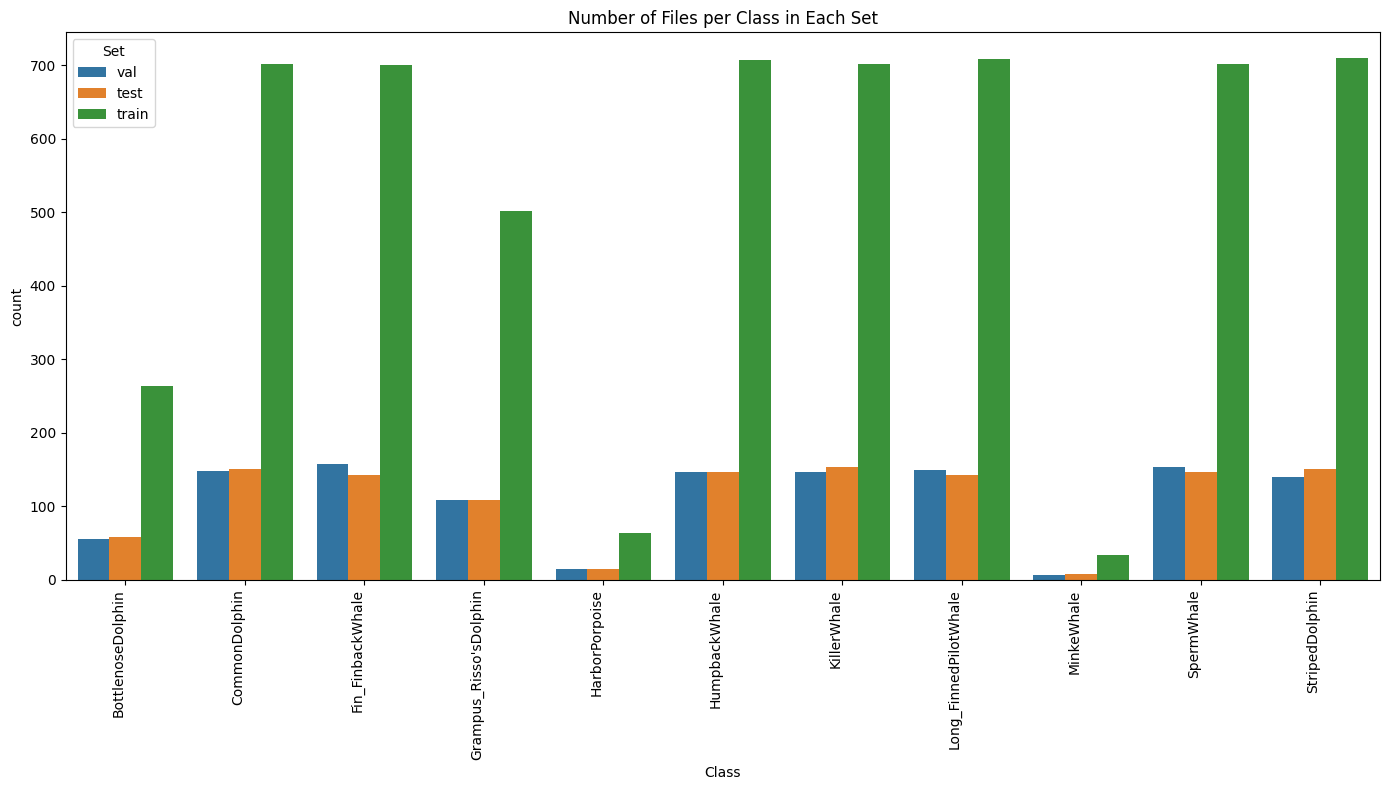

In [189]:
# plot split by Subset in df_wmm
plt.figure(figsize=(14, 8))
sns.countplot(data=df_wmm, x='Class', hue='Subset')
plt.title('Number of Files per Class in Each Set')
plt.xticks(rotation=90, ha='right', fontsize=10)  # Adjust fontsize and alignment
plt.legend(title='Set')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

### Neus - Marine Mammals

In [190]:
# Main Folder with all classes and files
main_folder = '../../Dataset/Audios/Neus/Marine Mammals/'

# Folder contains subfolders = classes and in them, the audio sample
classes = os.listdir(main_folder)

# remove folder Segmented
# classes.remove('Segmented')

# delete README.MD
# classes.remove('README.MD')

# Create an empty list to store the audio file paths
audio_files = []

# Loop through all the subfolders and files
for subfolder in classes:
    # Get the list of all files in the subfolder
    files = os.listdir(main_folder + subfolder)
    # Loop through all the files
    for f in files:
        # Get the full path of the file
        audio_files.append(main_folder + subfolder + '/' + f)

df_neus_mm = pd.DataFrame(audio_files, columns=['File'])

# Add class
df_neus_mm['Class'] = df_neus_mm['File'].apply(lambda x: x.split('/')[-2])

# Number of files per class and duration of each file
for f in audio_files:
    # Load the audio file
    x, sr = librosa.load(f)
    # Duration of the audio file
    duration = librosa.get_duration(y=x, sr=sr)
    # Add the duration to the duration list
    df_neus_mm.loc[df_neus_mm['File'] == f, 'Duration'] = duration

# If Class Dd then CommonDolphin, Gm then Grampus_Risso'sDolphin, Hb then HumpbackWhale, Kk then KillerWhale, Lf then Long_FinnedPilotWhale, Mw then MinkeWhale, Rt then Rough_ToothedDolphin, Sw then SpermWhale, Sd then StripedDolphin
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: 'CommonDolphin' if x == 'Dd' else x)
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: "Long_FinnedPilotWhale" if x == 'Gm' else x)
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: 'KillerWhale' if x == 'Oo' else x)
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: 'SpermWhale' if x == 'Pm' else x)
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: 'StripedDolphin' if x == 'Sc' else x)

In [191]:
# row with KillerWhale extract
df_KW = df_neus_mm[df_neus_mm['Class'] == 'KillerWhale'] # 1 audio
# row with SpermWhale extract
df_SW = df_neus_mm[df_neus_mm['Class'] == 'SpermWhale'] # 2 audios
# row with StripDolphin extract
df_SD = df_neus_mm[df_neus_mm['Class'] == 'StripedDolphin'] # 1 audio

# df_neus is all but the 3 classes
df_neus_mm = df_neus_mm[~df_neus_mm['Class'].isin(['KillerWhale', 'SpermWhale', 'StripedDolphin'])]

In [192]:
# split neus
df_train_neus, df_val_neus, df_test_neus_mm, _, _, _ = split_dataset(df_neus_mm, train_size=0.7, val_size=0.15, test_size=0.15)

In [193]:
# add KillerWhale and StripedDolphin to train
df_train_neus = pd.concat([df_train_neus, df_KW, df_SD])
# Split SpermWhale in half for train and validation
df_train_neus = pd.concat([df_train_neus, df_SW.iloc[:1]])
df_val_neus = pd.concat([df_val_neus, df_SW.iloc[1:]])

In [194]:
df_train_neus["Subset"] = "train"
df_val_neus["Subset"] = "val"
df_test_neus_mm["Subset"] = "test"

df_neus_mm = pd.concat([df_train_neus, df_val_neus, df_test_neus_mm])

In [195]:
df_neus_mm

,File,Class,Duration,Subset
0,../../Dataset/Audios/Neus/Marine Mammals/Dd/DD...,CommonDolphin,20.517868,train
1,../../Dataset/Audios/Neus/Marine Mammals/Dd/DD...,CommonDolphin,20.826304,train
2,../../Dataset/Audios/Neus/Marine Mammals/Dd/al...,CommonDolphin,195.658866,train
3,../../Dataset/Audios/Neus/Marine Mammals/Gm/al...,Long_FinnedPilotWhale,4239.202086,train
4,../../Dataset/Audios/Neus/Marine Mammals/Gm/ju...,Long_FinnedPilotWhale,388.340907,train
5,../../Dataset/Audios/Neus/Marine Mammals/Gm/al...,Long_FinnedPilotWhale,132.860136,train
6,../../Dataset/Audios/Neus/Marine Mammals/Dd/DD...,CommonDolphin,20.772336,train
7,../../Dataset/Audios/Neus/Marine Mammals/Gm/al...,Long_FinnedPilotWhale,129.096417,train
8,../../Dataset/Audios/Neus/Marine Mammals/Gm/ma...,Long_FinnedPilotWhale,666.286576,train
14,../../Dataset/Audios/Neus/Marine Mammals/Oo/ju...,KillerWhale,1613.952018,train


In [197]:
# For each file in the dataset, process the audio segmenting it in 3 seconds windows, if any of the segments is shorter, save it if it is at least 0.2 second long
# Create a new dataframe with the processed files maintaining original FilePath, Class, Subset, and Duration and include SegmentPath
processed_files = []

# target_sr = 48000
duration = 3

min_duration = 2

for _, row in df_neus_mm.iterrows():

    # Load audio
    file_path = row["File"]
    audio, audio_sr = librosa.load(file_path, sr=None)

    # print("Audio Sample Rate: ", audio_sr)
    # print("Audio Duration: ", len(audio) / audio_sr)
    # print("Audio Samples: ", len(audio))
    
    # Calculate the maximum length in samples and min length in samples
    max_length = audio_sr * duration  # e.g., 48000 * 3
    min_length = audio_sr * min_duration  # e.g., 48000 * 1
    
    # If the signal is shorter than the desired length, save
    if min_length <= len(audio) <= max_length:
        # start_sample = int(Fs * (row['StartSecond'] + 1))  # Convertir a muestras
        # end_sample = int(Fs * (row['EndSecond'] + 1))  # Convertir a muestras
        audio_class = row['Class']

        # Crear la carpeta para la clase
        class_folder = "../../Dataset/Audios/Neus/Segmented/" + audio_class
        os.makedirs(class_folder, exist_ok=True)

        end_second = len(audio) / audio_sr
        end_second = round(end_second, 2)

        # Guardar el segmento
        segment_path = row["File"].split("Neus")[0] + "Neus/Segmented/" + audio_class + "/"	
        base_filename = os.path.basename(row["File"])
        segment_path += base_filename.replace(".wav", f"_0_{end_second}.wav")
        sf.write(segment_path, audio, audio_sr)

        processed_files.append({
            "FilePath": row["File"],
            "SegmentPath": segment_path,
            "Class": row["Class"],
            "Duration": len(audio) / audio_sr,
            "Origin": "Neus Marine Mammals",
            "Subset": row["Subset"]
        })
    
    # If the signal is longer than the desired length, split into 3-second windows
    elif len(audio) > max_length:

        for start in range(0, len(audio), max_length):
            end = start + max_length
            segment = audio[start:end]
            
            if min_length <= len(segment) <= max_length:
            #     padding = max_length - len(segment)
            #     pad_left = padding // 2
            #     pad_right = padding - pad_left
            #     segment = np.pad(segment, (pad_left, pad_right), mode='constant')
            
                # Save segment in corresponding folder
                audio_class = row['Class']
                class_folder = "../../Dataset/Audios/Neus/Segmented/" + audio_class
                os.makedirs(class_folder, exist_ok=True)

                start_second = start / audio_sr
                end_second = end / audio_sr

                # round to 2 decimal places
                end_second = round(end_second, 2)

                segment_path = row["File"].split("Neus")[0] + "Neus/Segmented/" + audio_class + "/"
                base_filename = os.path.basename(row["File"])
                segment_path += base_filename.replace(".wav", f"_{start_second}_{end_second}.wav")
                sf.write(segment_path, segment, audio_sr)

                processed_files.append({
                    "FilePath": row["File"],
                    "SegmentPath": segment_path,
                    "Class": row["Class"],
                    "Duration": len(segment) / audio_sr,
                    "Origin": "Neus Marine Mammals",
                    "Subset": row["Subset"]
                })

    else:
        # print audio not processed, sample rate, samples, and duration in seconds
        print("Audio not processed: ", row["File"])
        print("Sample Rate: ", audio_sr)
        print("Samples: ", len(audio))
        print("Duration: ", len(audio) / audio_sr)
        print("===========================")

df_processed_neus = pd.DataFrame(processed_files)

# save as CSV in CSV folder
df_processed_neus.to_csv("../../Dataset/CSVs/Datasets/NeusMarineMammalsSegmented.csv", index=False)

# print(len(df_processed_wmm))

In [157]:
# sum duration of not segmented files
df_neus_mm["Duration"].sum()

10097.45746031746

In [156]:
# sum duration of processed files
df_processed_neus["Duration"].sum()

198.82887499999998

### SEANIMALMOVE - Background (no clicks, no whistles)

In [127]:
# Load CSV
df_sam_background = pd.read_csv('../../Dataset/CSVs/DatasetMultiLabel3.csv')
# Insert in path ../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/{Path}
df_sam_background['File'] = df_sam_background['SegmentPath'].apply(lambda x: f"../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/{x}")
# Take only rows where NumClasses = 0
# df_sam_background = df_sam_background[df_sam_background['NumClasses'] == 0]

# Take only rows where Class list does not contains CLICK, Whistle,Batida,BatidaClicks or BatidaClicksRapidaCascabel
df_sam_background = df_sam_background[~df_sam_background['Class'].str.contains('CLICK|Whistle|Batida|BatidaClicks|BatidaClicksRapidaCascabel')]
df_sam_background_empty = df_sam_background[df_sam_background['NumClasses'] == 0]
df_sam_background = df_sam_background[df_sam_background['NumClasses'] > 0]
# Take 1000 random samples of the background
df_sam_background = df_sam_background.sample(min(5000, len(df_sam_background)), random_state=42).reset_index(drop=True)
df_sam_background_empty = df_sam_background_empty.sample(min(len(df_sam_background), len(df_sam_background_empty)), random_state=42).reset_index(drop=True)
df_sam_background = pd.concat([df_sam_background, df_sam_background_empty])
# Create Column Duration and set all to 3
df_sam_background['Duration'] = 3
# Keep only columns Path, Class and Duration
df_sam_background = df_sam_background[['File', 'Class', 'Duration']]
# Class column value = Background
df_sam_background['Class'] = 'Background'

In [129]:
# Rename column File as FilePath
df_sam_background = df_sam_background.rename(columns={'File': 'FilePath'})
df_sam_background["SegmentPath"] = df_sam_background["FilePath"]
df_sam_background["Origin"] = "SEANIMALMOVE"

In [130]:
df_train_bg, df_val_bg, df_test_sam_bg, _, _, _ = split_dataset(df_sam_background, train_size=0.7, val_size=0.15, test_size=0.15)

In [131]:
df_train_bg["Subset"] = "train"
df_val_bg["Subset"] = "val"
df_test_sam_bg["Subset"] = "test"

df_sam_background = pd.concat([df_train_bg, df_val_bg, df_test_sam_bg])

In [133]:
# resort columns: FilePath,SegmentPath,Class,Duration,Origin,Subset
df_sam_background = df_sam_background[['FilePath', 'SegmentPath', 'Class', 'Duration', 'Origin', 'Subset']]
# save csv in CSVs dataset folder
df_sam_background.to_csv("../../Dataset/CSVs/Datasets/SEANIMALMOVEBackgroundSegmented.csv", index=False)

## Neus - Background (Anthropogenic, ferries)

In [141]:
# Background ferries
# Read all audio files in the input folder and its subfolders and set them as class Background
# Main Folder with all classes and files
main_folder = '../../Dataset/Audios/Neus/Anthropogenic/'

# Look for any .wav file in the folder or any subfolder
audio_files = []
for root, _, files in os.walk(main_folder):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))

df_bg_ff_neus = pd.DataFrame(audio_files, columns=['File'])

# Add class
df_bg_ff_neus['Class'] = "Background"
# total_duration = 0
# Number of files per class and duration of each file
for f in audio_files:
    
    # Load the audio file
    x, sr = librosa.load(f)
    # Duration of the audio file
    duration = librosa.get_duration(y=x, sr=sr)
    # Add the duration to the duration list
    df_bg_ff_neus.loc[df_bg_ff_neus['File'] == f, 'Duration'] = duration
    # total_duration += duration

# # Take half of the files by randomness
# df_bg_ff_neus = df_bg_ff_neus.sample(len(df_bg_ff_neus) // 2, random_state=42).reset_index(drop=True)

In [142]:
df_bg_ff_neus

,File,Class,Duration
0,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,140.839819
1,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,136.264898
2,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,120.102313
3,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,151.027982
4,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,20.424490
5,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,20.505125
6,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,20.391293
7,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,20.561814
8,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,20.416780
9,../../Dataset/Audios/Neus/Anthropogenic/Regist...,Background,12.773016


In [143]:
# Split background
df_train_bg_ff_neus, df_val_bg_ff_neus, df_test_bg_ff_neus, _, _, _ = split_dataset(df_bg_ff_neus, train_size=0.7, val_size=0.15, test_size=0.15)

In [144]:
df_train_bg_ff_neus["Subset"] = "train"
df_val_bg_ff_neus["Subset"] = "val"
df_test_bg_ff_neus["Subset"] = "test"

df_bg_ff_neus = pd.concat([df_train_bg_ff_neus, df_val_bg_ff_neus, df_test_bg_ff_neus])

In [146]:
# For each file in the dataset, process the audio segmenting it in 3 seconds windows, if any of the segments is shorter, save it if it is at least 0.2 second long
# Create a new dataframe with the processed files maintaining original FilePath, Class, Subset, and Duration and include SegmentPath
processed_files = []

# target_sr = 48000
duration = 3

min_duration = 3

audio_class = "Background"

for _, row in df_bg_ff_neus.iterrows():

    # Load audio
    file_path = row["File"]
    audio = AudioSegment.from_wav(file_path)

    # get audio sample rate
    audio_sr = audio.frame_rate
    # print("Audio Sample Rate: ", audio_sr)
    # print("Audio Duration: ", len(audio) / audio_sr)
    # print("Audio Samples: ", len(audio))
    
    # Calculate the maximum length in samples and min length in samples
    max_length = audio_sr * duration  # e.g., 48000 * 3
    min_length = audio_sr * min_duration  # e.g., 48000 * 1
    
    # If the signal is shorter than the desired length, save
    if min_length <= len(audio) <= max_length:
        # start_sample = int(Fs * (row['StartSecond'] + 1))  # Convertir a muestras
        # end_sample = int(Fs * (row['EndSecond'] + 1))  # Convertir a muestras

        # Crear la carpeta para la clase
        class_folder = "../../Dataset/Audios/Neus/Segmented/" + audio_class
        os.makedirs(class_folder, exist_ok=True)

        end_second = len(audio) / audio_sr
        end_second = round(end_second, 2)

        # Guardar el segmento
        segment_path = row["File"].split("Neus")[0] + "Neus/Segmented/" + audio_class + "/"	
        base_filename = os.path.basename(row["File"])
        segment_path += base_filename.replace(".wav", f"_0_{end_second}.wav")
        audio.export(segment_path, format="wav")

        processed_files.append({
            "FilePath": row["File"],
            "SegmentPath": segment_path,
            "Class": row["Class"],
            "Duration": len(audio) / audio_sr,
            "Origin": "Neus Background Fast Ferries",
            "Subset": row["Subset"]
        })
    
    # If the signal is longer than the desired length, split into 3-second windows
    elif len(audio) > max_length:

        for start in range(0, len(audio), max_length):
            end = start + max_length
            segment = audio[start:end]
            
            if min_length <= len(segment) <= max_length:
            #     padding = max_length - len(segment)
            #     pad_left = padding // 2
            #     pad_right = padding - pad_left
            #     segment = np.pad(segment, (pad_left, pad_right), mode='constant')
            
                # Save segment in corresponding folder
                # audio_class = row['Class']
                class_folder = "../../Dataset/Audios/Neus/Segmented/" + audio_class
                os.makedirs(class_folder, exist_ok=True)

                start_second = start / audio_sr
                end_second = end / audio_sr

                # round to 2 decimal places
                end_second = round(end_second, 2)

                segment_path = row["File"].split("Neus")[0] + "Neus/Segmented/" + audio_class + "/"
                base_filename = os.path.basename(row["File"])
                segment_path += base_filename.replace(".wav", f"_{start_second}_{end_second}.wav")
                print(segment_path)
                segment.export(segment_path, format="wav")

                processed_files.append({
                    "FilePath": row["File"],
                    "SegmentPath": segment_path,
                    "Class": row["Class"],
                    "Duration": len(segment) / audio_sr,
                    "Origin": "Neus Background Fast Ferries",
                    "Subset": row["Subset"]
                })

df_processed_neus = pd.DataFrame(processed_files)

# save as CSV in CSV folder
df_processed_neus.to_csv("../../Dataset/CSVs/Datasets/NeusBackgroundFastFerries.csv", index=False)

# print(len(df_processed_wmm))

../../Dataset/Audios/Neus/Segmented/Background/cargoToledoSpiryt120m19nudoswav_0.0_3.0.wav
../../Dataset/Audios/Neus/Segmented/Background/Comarit100m20nudos_0.0_3.0.wav
../../Dataset/Audios/Neus/Segmented/Background/cargoFreyna55m15nudoswav_0.0_3.0.wav


In [ ]:
# Add class Background to classes
CLASSES = np.append(CLASSES, 'Background')
# sORT alphabetically
CLASSES.sort()

# include CLASSES_MAPPING, REVERSE_CLASSES_MAPPING the background class as the first class
CLASSES_MAPPING = {CLASSES[i]: i for i in range(len(CLASSES))}
REVERSE_CLASSES_MAPPING = {v: k for k, v in CLASSES_MAPPING.items()}
CLASSES, CLASSES_MAPPING, REVERSE_CLASSES_MAPPING

(array(['Background', 'BottlenoseDolphin', 'CommonDolphin',
        'Fin_FinbackWhale', "Grampus_Risso'sDolphin", 'HarborPorpoise',
        'HumpbackWhale', 'KillerWhale', 'Long_FinnedPilotWhale',
        'MinkeWhale', 'SpermWhale', 'StripedDolphin'], dtype=object),
 {'Background': 0,
  'BottlenoseDolphin': 1,
  'CommonDolphin': 2,
  'Fin_FinbackWhale': 3,
  "Grampus_Risso'sDolphin": 4,
  'HarborPorpoise': 5,
  'HumpbackWhale': 6,
  'KillerWhale': 7,
  'Long_FinnedPilotWhale': 8,
  'MinkeWhale': 9,
  'SpermWhale': 10,
  'StripedDolphin': 11},
 {0: 'Background',
  1: 'BottlenoseDolphin',
  2: 'CommonDolphin',
  3: 'Fin_FinbackWhale',
  4: "Grampus_Risso'sDolphin",
  5: 'HarborPorpoise',
  6: 'HumpbackWhale',
  7: 'KillerWhale',
  8: 'Long_FinnedPilotWhale',
  9: 'MinkeWhale',
  10: 'SpermWhale',
  11: 'StripedDolphin'})

## Final Dataset

In [ ]:
# Concat all dataframes
df_train = pd.concat([df_train_wmm, df_train_neus, df_train_bg, df_train_bg_ff_neus])
df_val = pd.concat([df_val_wmm, df_val_neus, df_val_bg, df_val_bg_ff_neus])
df_test = pd.concat([df_test_wmm, df_test_neus_mm, df_test_sam_bg, df_test_bg_ff_neus])

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
df_background = pd.concat([df_train_bg, df_train_bg_ff_neus])
df_background = df_background.reset_index(drop=True)

In [ ]:
# Create df with column Set
df_train['Set'] = 'Train'
df_val['Set'] = 'Validation'
df_test['Set'] = 'Test'

# Concatenate all dataframes
df = pd.concat([df_train, df_val, df_test])

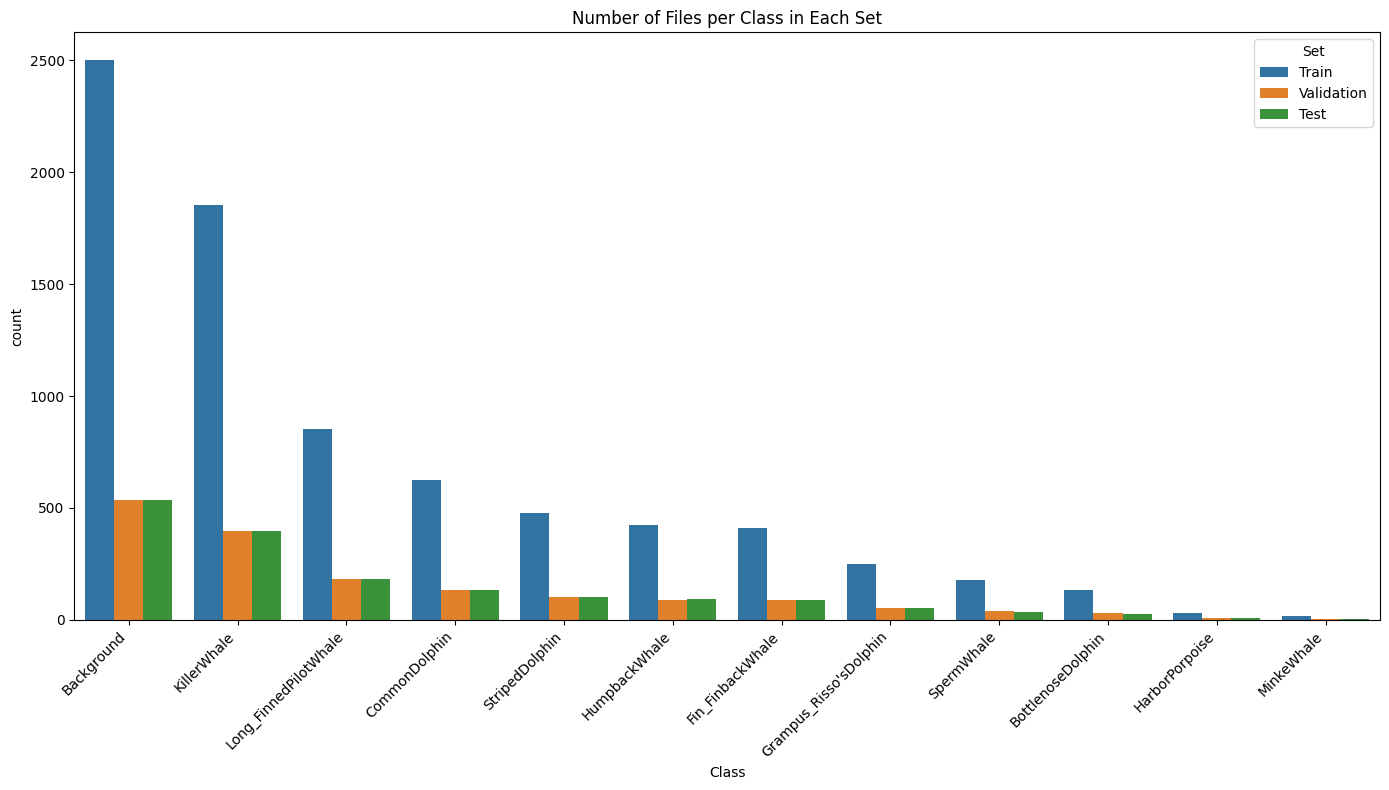

In [ ]:
# Plot count per class, each subset is a bar for each class (train, val and test)
class_counts = df['Class'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Class', hue='Set', order=class_counts.index)
plt.title('Number of Files per Class in Each Set')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust fontsize and alignment
plt.legend(title='Set')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

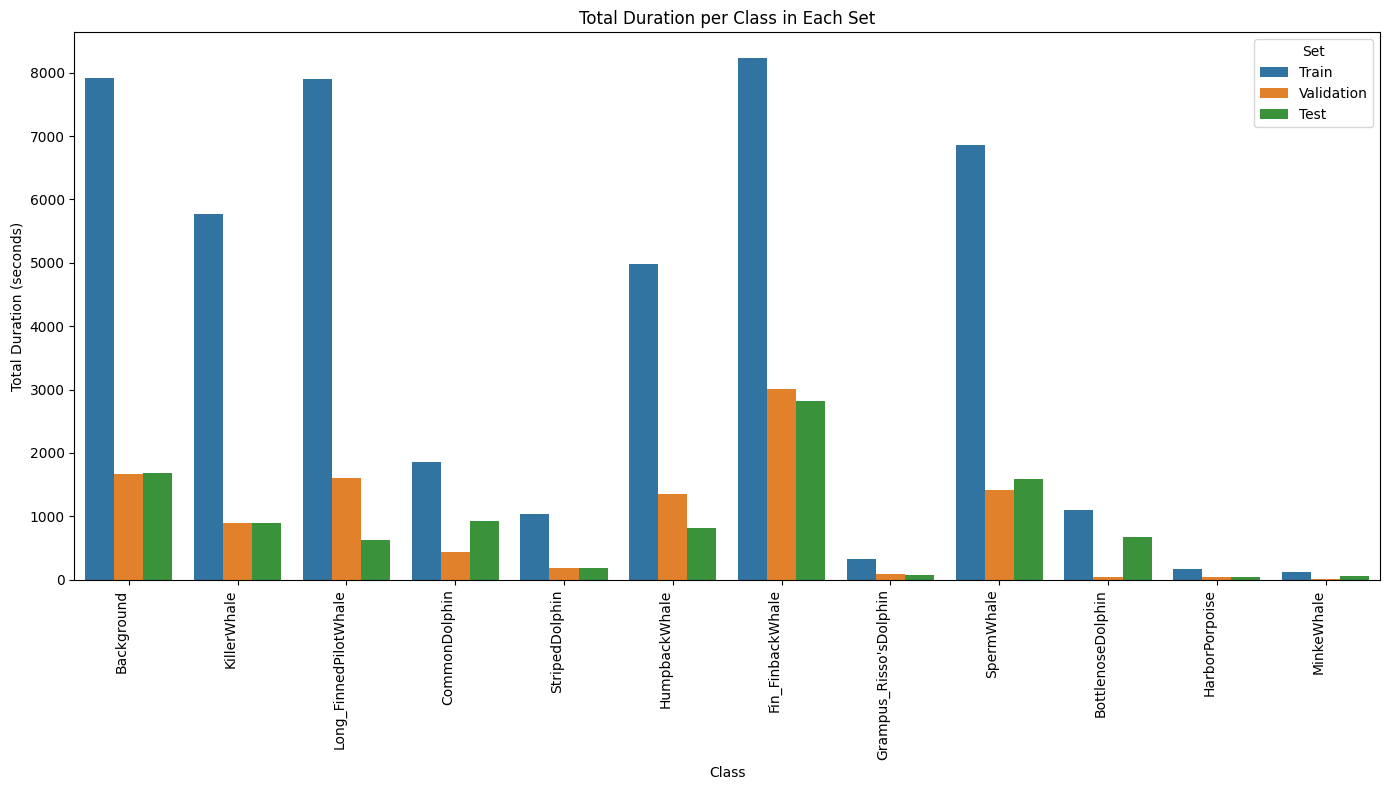

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_train, df_val, df_test are already defined and have a 'Duration' column

# Add 'Set' column
df_train['Set'] = 'Train'
df_val['Set'] = 'Validation'
df_test['Set'] = 'Test'

# Concatenate all dataframes
df = pd.concat([df_train, df_val, df_test])

# Aggregate total duration per class and subset
duration_df = df.groupby(['Class', 'Set'])['Duration'].sum().reset_index()

# Ensure the order of the bars is Train, Validation, and Test
duration_df['Set'] = pd.Categorical(duration_df['Set'], categories=['Train', 'Validation', 'Test'], ordered=True)

# Plot the total duration per class and subset
plt.figure(figsize=(14, 8))
sns.barplot(data=duration_df, x='Class', y='Duration', hue='Set', order=class_counts.index)
plt.title('Total Duration per Class in Each Set')
plt.xticks(rotation=90, ha='right', fontsize=10)  # Adjust fontsize and alignment
plt.ylabel('Total Duration (seconds)')
plt.legend(title='Set')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [ ]:
# reset index in all sets
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
CLASSES_MAPPING

{'Background': 0,
 'BottlenoseDolphin': 1,
 'CommonDolphin': 2,
 'Fin_FinbackWhale': 3,
 "Grampus_Risso'sDolphin": 4,
 'HarborPorpoise': 5,
 'HumpbackWhale': 6,
 'KillerWhale': 7,
 'Long_FinnedPilotWhale': 8,
 'MinkeWhale': 9,
 'SpermWhale': 10,
 'StripedDolphin': 11}